In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
import ana as ana
import seaborn as sns
import Bio as bio
from Bio import PDB
import warnings
import pdb_tools

Ignore Biopython warnings

In [29]:
from Bio import BiopythonWarning
warnings.filterwarnings("ignore", category=BiopythonWarning)

Load data

In [15]:
hbonds = np.load(file="coords/hb_small.npy")
hbonds_df = pd.DataFrame(hbonds, columns=["frame", "donor_id", "hydrogen_id", "acceptor_id", "distance", "angle"])
hbonds_df["frame"] = hbonds_df["frame"].astype(int)
hbonds_df["donor_id"] = hbonds_df["donor_id"].astype(int)
hbonds_df["hydrogen_id"] = hbonds_df["hydrogen_id"].astype(int)
hbonds_df["acceptor_id"] = hbonds_df["acceptor_id"].astype(int)
hbonds_df

,frame,donor_id,hydrogen_id,acceptor_id,distance,angle
0,0,46137,46138,46236,2.270508,171.438620
1,1,46236,46237,1116,2.263359,166.501215
2,1,46245,46246,7094,2.643274,165.738242
3,2,46209,46210,2209,2.775673,155.073331
4,2,46236,46237,1116,2.848134,154.027911
...,...,...,...,...,...,...
24423,2400,87876,87878,5830,2.796545,161.660227
24424,2400,92028,92030,7118,2.257973,153.534983
24425,2400,94944,94945,1116,2.203151,168.749616
24426,2400,99108,99109,4016,2.217733,171.218983


Analyze what the data actually looks like

Text(0, 0.5, 'count')

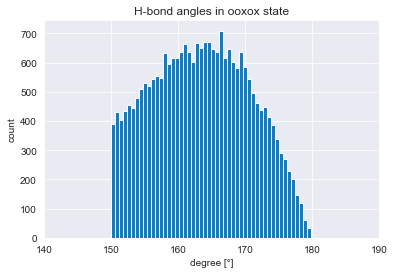

In [16]:
plt.hist(hbonds_df["angle"], bins=50)
plt.xlim([140, 190])
plt.title("H-bond angles in ooxox state")
plt.xlabel("degree [°]")
plt.ylabel("count")

Why is there a limit for h-bond angles at 150°? https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8261469/

Text(0, 0.5, 'count')

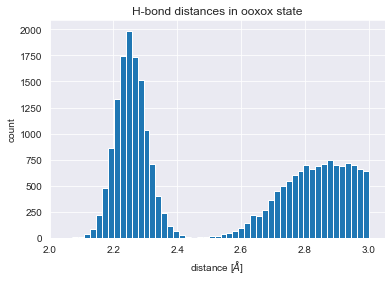

In [17]:
plt.hist(hbonds_df["distance"], bins=50)
plt.xlim([2, 3.05])
plt.title("H-bond distances in ooxox state")
plt.xlabel(r"distance [$\AA$]")
plt.ylabel("count")

Why is there a cutoff at 3\AA? 

Analyze how many Hbonds over time (hbonds/timeframe)

In [18]:
value_counts_df = pd.DataFrame(hbonds_df["frame"].value_counts()).reset_index()
value_counts_df.columns = ['value', 'hbond_count']
sorted_df = value_counts_df.sort_values("value")
sorted_df = sorted_df.reset_index(drop=True)
sorted_df

,value,hbond_count
0,0,1
1,1,2
2,2,2
3,3,2
4,4,2
...,...,...
2395,2396,16
2396,2397,20
2397,2398,16
2398,2399,13


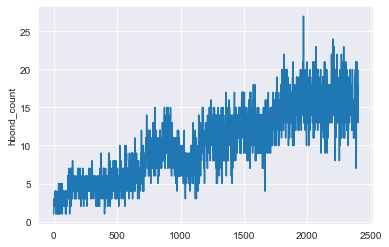

In [19]:
#plt.plot(sorted_df["hbond_count"])
sns.lineplot(data=sorted_df["hbond_count"], estimator=np.mean, ci=95)
sns.set_style('darkgrid')

Analyze which partners are involved most in hbonds

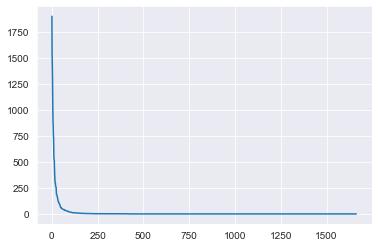

In [20]:
value_counts_df = pd.DataFrame(hbonds_df["donor_id"].value_counts()).reset_index()
value_counts_df.columns = ['value', 'hbond_count']
value_counts_df
plt.plot(value_counts_df["hbond_count"])

Most H-bonds in most frames are donated by only a very few donor molecules (Some donors are really active and most atoms do not form hbonds around the hemes)

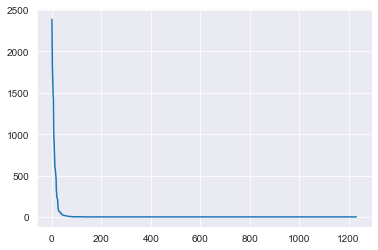

In [21]:
value_counts_df = pd.DataFrame(hbonds_df["acceptor_id"].value_counts()).reset_index()
value_counts_df.columns = ['value', 'hbond_count']
value_counts_df
plt.plot(value_counts_df["hbond_count"])

Most H-bonds in most frames are accepted by a very few acceptor molecules (Some acceptors are really active and most atoms do not form hbonds around the hemes)

Which molecules are most involved in the h-bonds? (Map numbers to atoms by first getting the atom and residue information from the PDB)

In [57]:
pdb_file = "coords/3hb3_ooxox.pdb"
#parser = PDB.PDBParser()
#structure = parser.get_structure("structure_id", pdb_file)
#atom_names = []
#residue_names_numbers = []
#for model in structure:
#    for chain in model:
#        for residue in chain:
#            residue_id = residue.get_id()
#            residue_number = residue_id[1]
#            residue_name = residue.get_resname()
#            for atom in residue:
#                atom_name = atom.get_name()
#                atom_names.append(atom_name)
#                residue_names_numbers.append(f"{residue_name}{residue_number}")

donor_df, acceptor_df = pd.DataFrame(), pd.DataFrame()

lines = pdb_tools.files.read_file(pdb_file='coords/3hb3_ooxox.pdb')
line_number=0
for line in lines:
    line_dict = pdb_tools.line_operations.read_pdb_line(line)
    donor_df.loc[line_number, 'donor_id'] = str(int(line_dict['serial_no'])-1)
    donor_df.loc[line_number, 'donor_resname'] = line_dict['resname']
    donor_df.loc[line_number, 'donor_resno'] = line_dict['resi_no']
    line_number+=1
donor_df



#donor_df['donor_names'] = atom_names
#donor_df['donor_resi'] = residue_names_numbers
#donor_df['donor_id'] = donor_df.index

#acceptor_df['acceptor_names'] = atom_names
#acceptor_df['acceptor_resi'] = residue_names_numbers
#acceptor_df['acceptor_id'] = acceptor_df.index

ValueError: invalid literal for int() with base 10: '*****'

In [46]:
donor_df

,donor_names,donor_resi,donor_id
0,N,GLY17,0
1,HN,GLY17,1
2,CA,GLY17,2
3,HA1,GLY17,3
4,HA2,GLY17,4
...,...,...,...
63872,H1,TIP9998,63872
63873,H2,TIP9998,63873
63874,OH2,TIP9999,63874
63875,H1,TIP9999,63875


In [48]:
acceptor_df

,acceptor_names,acceptor_resi,acceptor_id
0,N,GLY17,0
1,HN,GLY17,1
2,CA,GLY17,2
3,HA1,GLY17,3
4,HA2,GLY17,4
...,...,...,...
63872,H1,TIP9998,63872
63873,H2,TIP9998,63873
63874,OH2,TIP9999,63874
63875,H1,TIP9999,63875


Now merge the dataframes so that the atom names and residue_names_numbers information is accessible in the original dataframe

In [47]:
joined_df = pd.merge(hbonds_df, donor_df, on='donor_id', how='left')
joined_df = pd.merge(joined_df, acceptor_df, on='acceptor_id', how='left')
joined_df

,frame,donor_id,hydrogen_id,acceptor_id,distance,angle,donor_names,donor_resi,acceptor_names,acceptor_resi
0,0,46137,46138,46236,2.270508,171.438620,H2,TIP4086,H2,TIP4119
1,1,46236,46237,1116,2.263359,166.501215,H2,TIP4119,OD1,ASN88
2,1,46245,46246,7094,2.643274,165.738242,H2,TIP4122,O,PRO472
3,2,46209,46210,2209,2.775673,155.073331,H2,TIP4110,O,GLY161
4,2,46236,46237,1116,2.848134,154.027911,H2,TIP4119,OD1,ASN88
...,...,...,...,...,...,...,...,...,...,...
24423,2400,87876,87878,5830,2.796545,161.660227,NaN,NaN,O,SER394
24424,2400,92028,92030,7118,2.257973,153.534983,NaN,NaN,O,ARG473
24425,2400,94944,94945,1116,2.203151,168.749616,NaN,NaN,OD1,ASN88
24426,2400,99108,99109,4016,2.217733,171.218983,NaN,NaN,OE2,GLU278


Are those forming hbonds with each other? Are they stable?

Are those partners forming stable hbonds (visible in more frames)?

Are those that form stable hbonds switching up into interesting other hbonds?

Are the stable hbonds the same as in the crystal structure, or in the model that Jovan proposed?